# Central Limit Theorem (CLT)

The aim of this notebook is to illustrate the Central Limit Theorem (CLT) through concrete examples.

When you add random numbers from different distributions, but with similar variance (or standard deviation), together and plot the distribution of these sums, you end up with a Gaussian distribution, as dictated by the CLT. 
The example also illustrates how widths (and therefore uncertainties) are added in quadrature, as one has to divide the sum by the square root of the number of random numbers that went into the sum in order to get a Gaussian of unit width (when using random numbers of unit width, i.e. RMSE $= \sigma = 1$).


## References:
- **R. Barlow**: page 49 (and page 45 for Uniform distribution)
- **G. Cowan**: page 33
- __[Wikipedia: "Central limit theorem"](http://en.wikipedia.org/wiki/Central_limit_theorem)__

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   25th of November 2021

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories

Here we set the random seed for the random number generator (RNG). This ensures reproducability (the same results every time the notebook is restarted). 

In [2]:
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed (but a fixed one - more on that later.)

And here we set the parameters for the experiement. We are going to play around with these more.
For now we choose to take __10 uniform numbers__ and consider their sum __1000 times__. 

In [3]:
N_experiments = 1000                  # Number of sums produced
N_uniform     = 2                     # Number of uniform numbers used in sum
N_exponential = 0                     # Number of exponential numbers used in sum
N_cauchy      = 0                     # Number of cauchy numbers used in sum

And finally we set up some global constants and bool flags about the program:

In [4]:
verbose = True                        # Print some numbers or not?
N_verbose = 10                        # If so, how many?
save_plots = False                    # Save the plots produced to file(s)?

## Initial functions
We load the external functions from the `AppStat2021/External_Functions` directory. The first line adds the relevant path to the places it will go look for functions, and the second line imports the function wanted. If you get an error here, check that you have copied "External Functions" to your directory, and that you refer to the correct path.

In [5]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

## Loop over process:

Having loaded everything that we need, we can start the actual program. We start out by initializing a counter to count how many of the produced sums that fall outside some range ($\pm 3\sigma$) and some zero-filled numpy arrays:

In [6]:
N3_sigma = 0        # Counter for the number of produced sums, that fall outside +-3 sigma

x_uniform = np.zeros((N_uniform, N_experiments))
x_exponential = np.zeros((N_exponential, N_experiments))
x_cauchy = np.zeros((N_cauchy, N_experiments))
x_sum = np.zeros((N_experiments))

### Note on code:

We loop over "experiments" to make the code more explicit. This could in principle be avoided (which typically also makes the code faster), but for now we keep it, also to be able to comment on what goes on.

In [7]:
for iexp in range(N_experiments): 

    if ((iexp+1) % 500 == 0): 
        print("At iexp : ", iexp+1)         # Show progress!
    sum_value = 0.0                         # sum_value is the number we are going to add random numbers to!
                                            # According to the CLT, it should be Gaussianly distributed.
 
    # Generating uniform numbers (with mean 0, and RMS of 1):
    x_uniform[:, iexp] = (np.random.uniform(size=N_uniform) - 0.5) * np.sqrt(12)   # ...sqrt(12). Why? Possibly see references above!
    sum_value += x_uniform[:, iexp].sum()               # We add the numbers in "sum_value"

    # Generating exponential numbers (with mean 0, and RMS of 1):
    x_exponential[:, iexp] = np.random.exponential(size=N_exponential) - 1   # Exponential starting at -1. Why?
    sum_value += x_exponential[:, iexp].sum()

    # Generating numbers according to a Cauchy distribution (1 / (1 + x^2)):
    x_cauchy[:, iexp] = np.random.standard_cauchy(size=N_cauchy)
    sum_value += x_cauchy[:, iexp].sum()

    N_total = N_uniform + N_exponential + N_cauchy
    sum_value = sum_value / np.sqrt(N_total)              # Ask yourself, why I divide by sqrt(N)?
    x_sum[iexp] = sum_value

    # Count the number of times, that the sum is not within 3 sigma of a unit Gaussian:
    if not (-3.0 < sum_value < 3.0):
        N3_sigma += 1

At iexp :  500
At iexp :  1000


Now we have created three 2-dimensional arrays of shape (N_pdf, N_experiments), e.g. (10, 1000). We now flatten the arrays to get 1D arrays in order to see their distribution:

In [8]:
x_uniform = x_uniform.flatten()
x_exponential = x_exponential.flatten()
x_cauchy = x_cauchy.flatten()

## Plot the input distributions:

It is always important to visualize out data to see if our code produced the expected results, find outliers and just generally get a better understand of it.

We first define the number of bins and the ranges of the different distributions. Note that it is important to think about this - too many/few bins or poor choice of range may ruin the plot, and one should try to get a "regular" bin widths:

In [9]:
N_bins = 100
x_ranges = [(-2.5, 2.5), (-1.5, 8.5), (-5.0, 5.0)]

We now loop over our three distributions and plot them (if they are not empty). In each subplot we plot histograms of the distributions with the given number of bins and ranges as defined above and with the mean, standard deviation and truncated standard deviation for each distribution. 

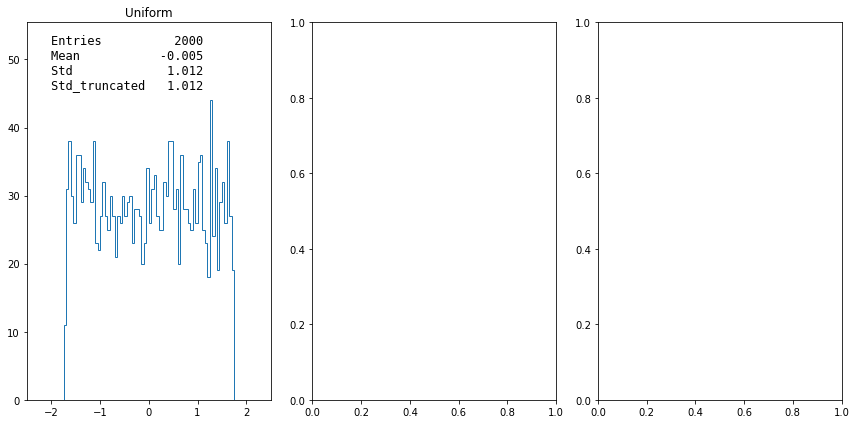

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

x_all = [x_uniform, x_exponential, x_cauchy]
titles = ['Uniform', 'Exponential', 'Cauchy']

# Here, we simultaneously loop "smartly" (using zip) over axis, x, titles, and ranges:
for ax_i, x, title, x_range in zip(ax, x_all, titles, x_ranges):    
    if len(x) > 0 :
        ax_i.hist(x, bins=N_bins, range=x_range, histtype='step')
        ymax = ax_i.get_ylim()[1]*1.2                              # Making a little space above the bins
        ax_i.set(title=title, ylim=(0, ymax), xlim=x_range)
        d = {'Entries': len(x),
             'Mean': x.mean(),
             'Std': x.std(ddof=1),                 # The truncated Std. includes only values inside range!
             'Std_truncated': x[(x_range[0]<x) & (x<x_range[1])].std(ddof=1),
        }
        text = nice_string_output(d, extra_spacing=2, decimals=3)
        add_text_to_ax(0.1, 0.97, text, ax_i, fontsize=12)

fig.tight_layout()

if save_plots:
    fig.savefig('Plot_CentralLimit_Input.pdf', dpi=600)

## Outside $\pm 3 \sigma$

Below we write how many of the experiments had a result outside the range [-3,3], i.e. beyond $\pm 3 \sigma$:

In [11]:
print(f"Number of experiments beyond 3 sigma / total: {N3_sigma:4d} / {N_experiments:d} = {N3_sigma/N_experiments:6.4f}")

Number of experiments beyond 3 sigma / total:    0 / 1000 = 0.0000


- __Question__: *Do the numbers above make sense? What did you expect it to be?*
***
## Draw output plots with corresponding fits to the screen:

Having visualized the individual distributions above, we now visualize the sum of the different distributions, `x_sum`. We first plot a histogram of it in the range from `xmin` to `xmax`:

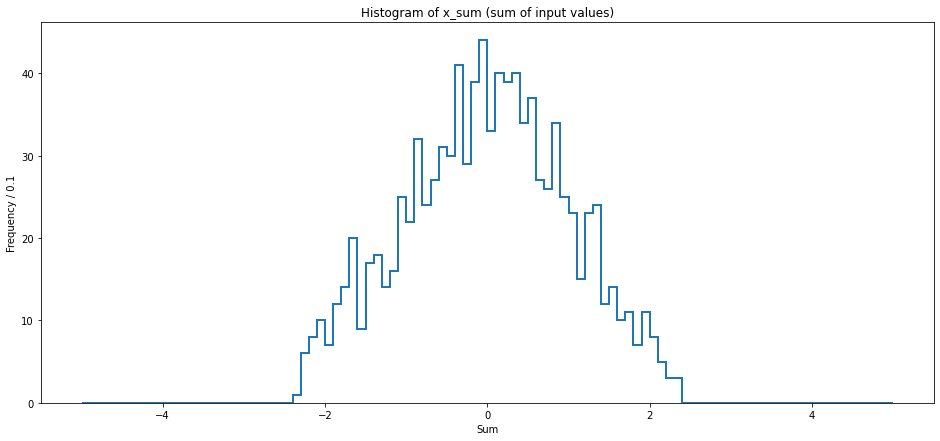

In [12]:
xmin, xmax = -5, 5

fig2, ax2 = plt.subplots(figsize=(16, 7)) 
hist2 = ax2.hist(x_sum, bins=N_bins, range=(xmin, xmax), histtype='step', linewidth=2)
ax2.set(xlabel='Sum', ylabel='Frequency / 0.1', title='Histogram of x_sum (sum of input values)');

Now we overlay the plot with a unit Gaussian (i.e. not fitted to the data), to see if the resulting sums actually distribute themselves Gaussianly:

In [13]:
# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

def gauss_extended(x, N, mu, sigma):
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

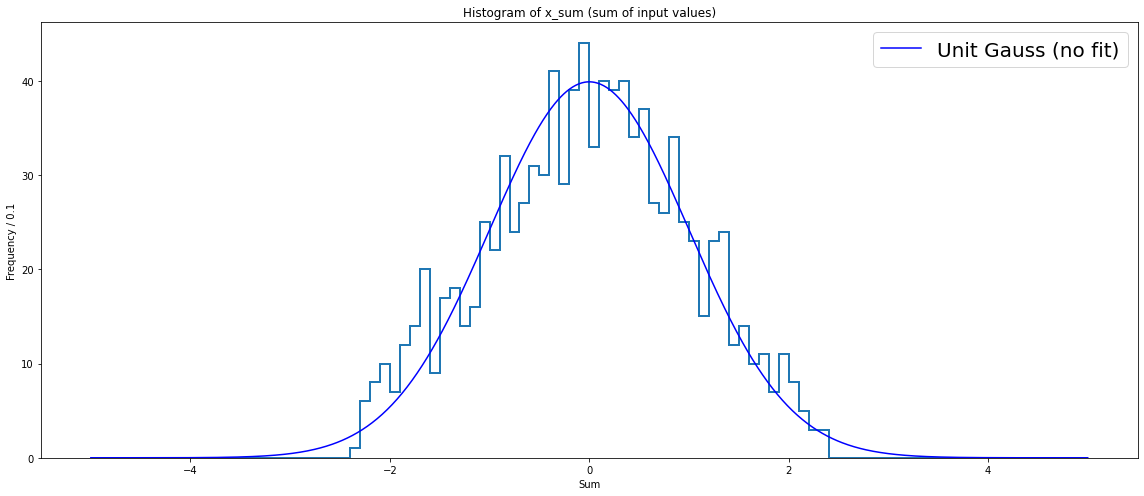

In [14]:
N_scale = (xmax-xmin) / N_bins            # The scale factor between histogram and the fit. Takes e.g. bin width into account.
x_gauss = np.linspace(xmin, xmax, 1000)   # Create the x-axis for the plot of the fitted function
y_gauss = N_scale*gauss_extended(x_gauss, len(x_sum), 0, 1)                   # Unit Gaussian
ax2.plot(x_gauss, y_gauss, '-', color='blue', label='Unit Gauss (no fit)') 
ax2.legend(loc='upper right', fontsize=20)
fig2.tight_layout()

# Note, we refer to the old plot "ax2". Had we done another plot in between, 
# we would not have been able to plot on top of the old figure with the matlab syntax.
if save_plots :
    fig2.savefig('Histogram.pdf', dpi=600)
fig2        

***

First make sure that you understand what the Central Limit Theorem (CLT) states! Then, acquaint yourself with the program. Make sure that you read through it, as many
of these features will be used onwards. Do you understand why the uniform distribution needs to go from $\pm \sqrt 3$ in order to give a distribution with a width of $1$ (i.e. unit) and why you subtract $1$ from the exponential distribution (and how this works at all)?

# Questions:

1. What is the mean and RMSE (i.e. Standard Deviation) of the input distributions?

**Example answer 1**:
The mean and RMS are 0 and 1, respectively, for both the Uniform and Exponential distributions. However, for the Cauchy the RMS is undefined (the integral does not converge!), and thus the mean is in fact also not defined (even if one from symmetry arguments would say 0).

---

2. Why is there a $\frac{1}{\sqrt N}$ at the bottom of cell [7] in the line `sum_value = sum_value / np.sqrt(Ntotal)` (when summing up the various contributions to sum)?
    Hint: Assume that I always wanted to compare the distribution of sums with a UNIT Gaussian.

**Example answer 2**:
The Central Limit Theorem (CLT) states, that the variances add (i.e. the widths = sigma are added in quadrature), thus the more contributions are added (say Ncontrib), the wider a distribution one would expect, growing as sqrt(Ncontrib). However, as we want to compare to the a UNIT Gaussian, we exactly divide by sqrt(Ncontrib).

---

3. Using a sum of 10 uniform random numbers with mean 0 and width 1, what is the expected 
    width of the resulting distribution according to CLT? What is the probability of
    obtaining a number beyond 3 sigma, i.e. how many numbers did you get beyond 3 sigma?
    What would you expect from a true Gaussian distribution?
    And what about the same question for 3.5 sigma? And 4.0 sigma?
    Put additional counters into the code, to test any effects in the tails (which have little statistics as it is).
    Increase the number of experiments run to (much) more than 1000...

**Example answer 3**:
As it happens, it is in fact not truly Gaussian in the tails, and one finds fewer events in the tails, than should be expected from a true Gaussian (around 1850 compared to 2700, if running a million cases, which is NOT statistically compatible!).

---

4. Now try to add 10 exponential (i.e. set `N_exponential=10` and rerun the program). Does that give something Gaussian? What about 1000?
    Then try to add 10 cauchy numbers (i.e. set `N_cauchy=10` and rerun the program). Does that give something Gaussian? What about 1000?
    If not Gaussian, why do the Cauchy distribution "ruin" the Gaussian distribution?
    And is this in conflict with the Central Limit Theorem?

**Example answer 4**:
Adding a contribution of 10 exponential numbers makes the resulting distribution visibly asymmetric. Suddenly, the number of cases outside 3 sigma fits better, while at 4 sigma, there are way too many. That is because the relatively few exponential numbers gives a larger tail to the upper/right part of the distribution.

Adding any contribution from the Cauchy distribution ruins everything - nothing converges, simply because this distribution does not have a well defined width, and hence any distribution which has a contribution from it also doesn't have a well defined width. This is not in conflict with the CLT, as this only applies for distributions with a well defined width (or variance).

---

### Advanced questions:

5. If one used a trunkated mean throwing away the top and bottom e.g. 10%,
    will the truncated mean of 1000 Cauchy numbers then converge to a Gaussian (possibly not with unit width)?

6. What is the lowest number of uniform random numbers needs to be added, before the probability
    for the sum to follow a Gaussian distribution is greater than 1% (on average)
    when considering 1000 sums (i.e. `N_experiments=1000`)? Here, a $\chi^2$ fit is needed.
   